In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample

In [14]:
rainfall_data = pd.read_csv('Rainfall.csv')

In [15]:
rainfall_data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [16]:
rainfall_data.shape

(366, 12)

In [17]:
rainfall_data.isnull().sum()

day                       0
pressure                  0
maxtemp                   0
temparature               0
mintemp                   0
dewpoint                  0
humidity                  0
cloud                     0
rainfall                  0
sunshine                  0
         winddirection    1
windspeed                 1
dtype: int64

In [18]:
# we are seeing an empty space here at winddirection coloumn so removing it
rainfall_data.columns = rainfall_data.columns.str.strip()

rainfall_data.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [19]:
rainfall_data = rainfall_data.drop(columns='day')

Handling missing values

In [20]:
rainfall_data['winddirection'] = rainfall_data['winddirection'].fillna(rainfall_data['winddirection'].mode()[0])
rainfall_data['windspeed'] = rainfall_data['windspeed'].fillna(rainfall_data['windspeed'].median())


In [21]:
rainfall_data['rainfall'] = rainfall_data['rainfall'].map({'yes':1, 'no':0})
rainfall_data.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,19.9,18.3,16.8,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,21.7,18.9,17.2,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,20.3,19.3,18.0,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,22.3,20.6,19.1,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,21.3,20.7,20.2,19.9,95,81,1,0.0,40.0,13.7


Exploratory Data Analysis

In [25]:
sns.set(style='whitegrid')
plt.Figure(figsize=(25,20))


<Figure size 2500x2000 with 0 Axes>

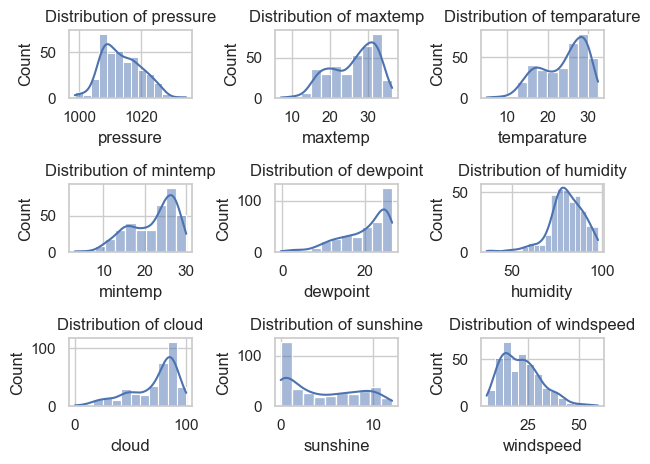

In [ ]:
for i, coloumn in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed'], 1):
  plt.subplot(3,3,i)
  sns.histplot(rainfall_data[coloumn], kde=True)
  plt.title(f"Distribution of {coloumn}")

plt.tight_layout()
plt.show()

we are not using standardization here as random forest classifier model or xgboost regressor etc dont need standardized models as they are advanced but SVMs and logistic regression models need standardized models as they are simpler

In [ ]:
rainfall_data['rainfall'].value_counts()
# not a ideal situation as 1's is much more than the 0's

rainfall
1    249
0    117
Name: count, dtype: int64

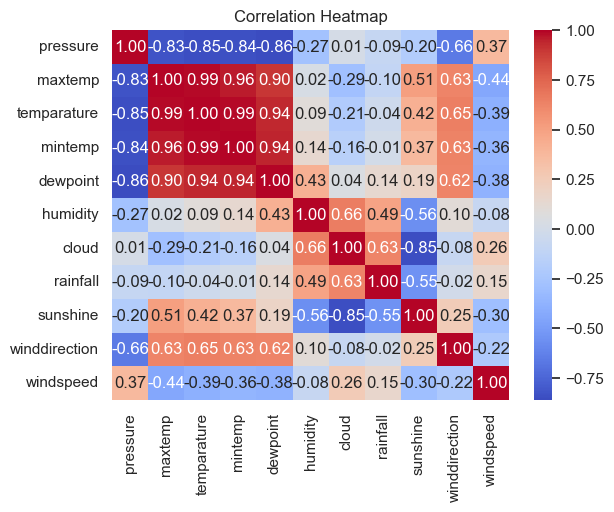

In [ ]:
# correlation matrix
plt.Figure(figsize=(20,16))
sns.heatmap(rainfall_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
# the highly red region is highly correlated

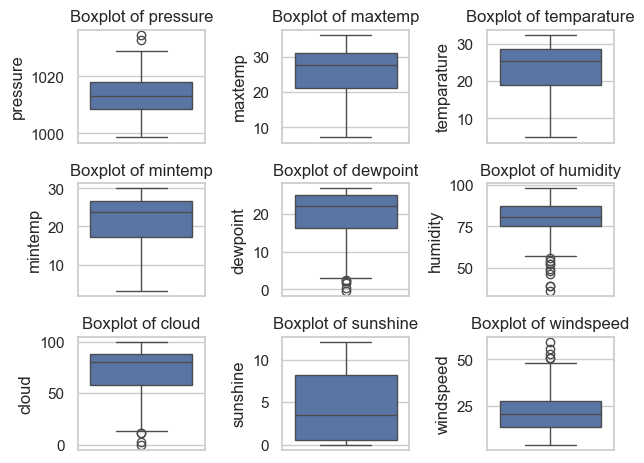

In [34]:
plt.Figure(figsize=(15,10))
for i, coloumn in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed'], 1):
  plt.subplot(3,3,i)
  sns.boxplot(rainfall_data[coloumn])
  plt.title(f"Boxplot of {coloumn}")

plt.tight_layout()
plt.show()

In [36]:
# drop higly correlated coloumn
rainfall_data = rainfall_data.drop(columns=['maxtemp', 'temparature', 'mintemp'])
rainfall_data.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,19.9,95,81,1,0.0,40.0,13.7


In [37]:
# separate majority and minority class
df_majority = rainfall_data[rainfall_data['rainfall'] == 1]
df_minority = rainfall_data[rainfall_data['rainfall'] == 0]

print(df_majority.shape)
print(df_minority.shape)

(249, 8)
(117, 8)


In [38]:
# downsampling the majority class to match minority class

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

In [41]:
print(df_majority_downsampled.shape)

(117, 8)


In [43]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [44]:
df_downsampled.shape

(234, 8)

In [45]:
# shuffling the final dataframe as 1st 117 are 1s and next 117 are 0
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_downsampled.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1022.2,14.1,78,90,1,0.0,30.0,28.5
1,1013.4,19.5,69,17,0,10.5,70.0,12.4
2,1006.1,24.4,74,27,0,10.8,220.0,8.7
3,1007.6,24.8,85,84,1,1.8,70.0,34.8
4,1021.2,8.4,66,18,0,10.1,20.0,24.4


In [51]:
# splitting the data

X = df_downsampled.drop(columns=['rainfall'])
Y = df_downsampled['rainfall']

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2, stratify=Y)
print(X.shape, X_train.shape, X_test.shape)

(234, 7) (187, 7) (47, 7)


Before hyper parameter tuning


In [53]:
model = RandomForestClassifier()

# training the model on training dataset
model.fit(X_train, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
# accuracy score on test data
test_data_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(test_data_prediction, Y_test)
print('Accuracy on test data : ', test_data_accuracy)

Accuracy on test data :  0.8085106382978723


In [58]:
# accuracy score on test data
train_data_prediction = model.predict(X_train)
train_data_accuracy = accuracy_score(train_data_prediction, Y_train)
print('Accuracy on training data : ', train_data_accuracy)

Accuracy on training data :  1.0


After Hyper parameter tuning

In [61]:
# model training is done, now we will do hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42)

# hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [62]:
# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [63]:
best_rf_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [64]:
cv_scores = cross_val_score(best_rf_model, X_train, Y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))

Cross-validation scores:  [0.78947368 0.73684211 0.72972973 0.75675676 0.81081081]
Mean cross-validation score:  0.7647226173541963


In [65]:
# test set performance
y_prediction = best_rf_model.predict(X_test)

print("Test set accuracy", accuracy_score(Y_test, y_prediction))
print("Test set Confusion matrix", confusion_matrix(Y_test, y_prediction))
print("Classification report", classification_report(Y_test, y_prediction))


Test set accuracy 0.8085106382978723
Test set Confusion matrix [[18  6]
 [ 3 20]]
Classification report               precision    recall  f1-score   support

           0       0.86      0.75      0.80        24
           1       0.77      0.87      0.82        23

    accuracy                           0.81        47
   macro avg       0.81      0.81      0.81        47
weighted avg       0.81      0.81      0.81        47



Prediction system

In [68]:
input_data = (1015.4,14.6,97,97,0,50,37.5)

input_df = pd.DataFrame([input_data], columns=X.columns)

print(input_df)

   pressure  dewpoint  humidity  cloud  sunshine  winddirection  windspeed
0    1015.4      14.6        97     97         0             50       37.5


In [69]:
prediction = best_rf_model.predict(input_df)
print("Prediction for input data: ", "Rainfall happening" if prediction[0] == 1 else "No Rainfall")

Prediction for input data:  Rainfall happening


In [70]:
import pickle

In [71]:
model_data = {"model": best_rf_model, "feature_names": X.columns.tolist()}

with open('rainfall_prediction_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)

In [72]:
# load the model
with open('rainfall_prediction_model.pkl', 'rb') as file:
    loaded_model_data = pickle.load(file)
    loaded_model_d = loaded_model_data['model']
    loaded_model_f = loaded_model_data['feature_names']

In [78]:
input_data = (1015.4,14.6,97,97,0,50,37.5)

input_df = pd.DataFrame([input_data], columns=X.columns)

prediction = loaded_model_d.predict(input_df)
print("Prediction for input data: ", "Rainfall happening" if prediction[0] == 1 else "No Rainfall")

Prediction for input data:  Rainfall happening
